# Real Bookshelf to Virtual Bookshelf 📚

The idea is to take an image of a real life bookshelf and generate a digital list of books, along with a Goodreads link for each of them. 

In [1]:
import cv2

import ipywidgets as widgets

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

%load_ext autoreload

%autoreload 1
%aimport utils
%aimport east
%aimport segment

In [2]:
cv2.__version__

'4.1.1'

## Upload an image

3024 4032


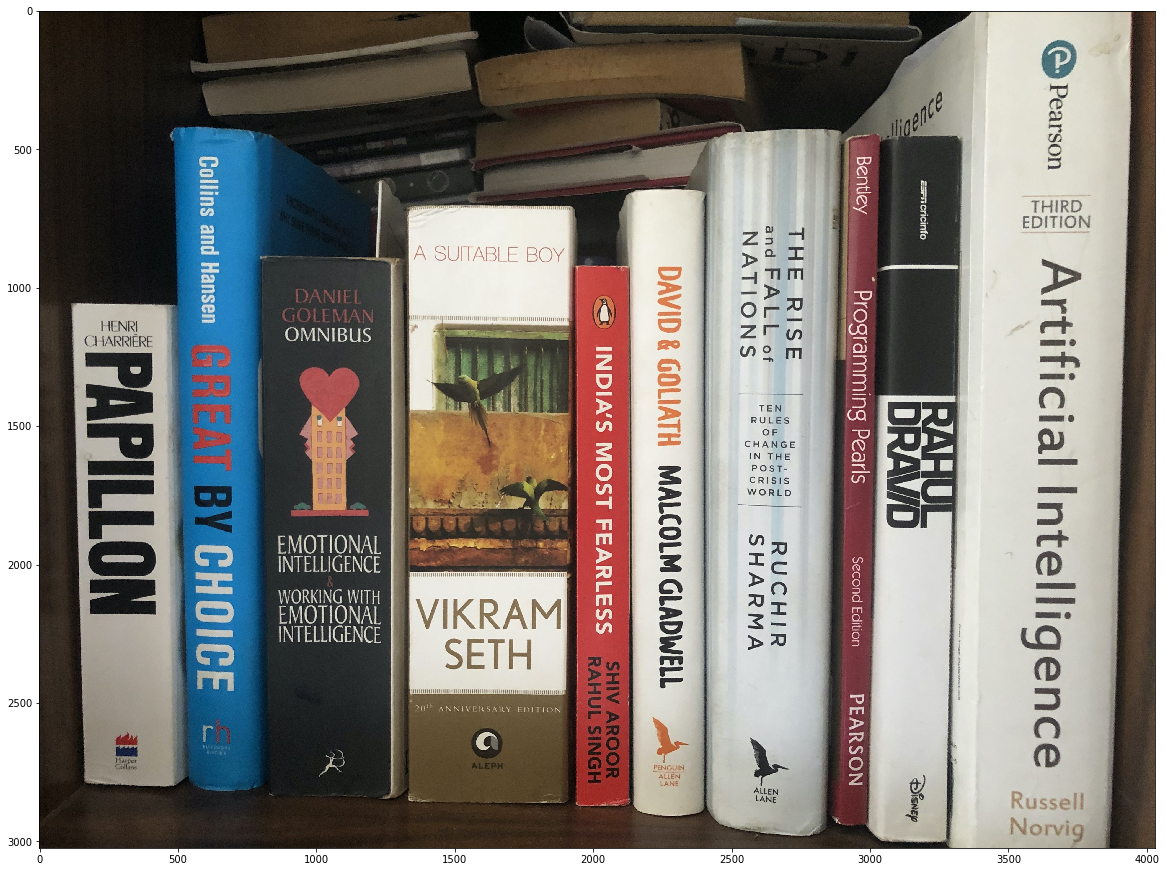

In [3]:
# Read the image
img = cv2.imread("images/bookshelf3b.jpeg")
#img = cv2.imread("images/bookshelf3a.jpeg")
height, width = img.shape[:2]

print(height,width)

utils.showImage(img,size=20)

## Pre-process the image

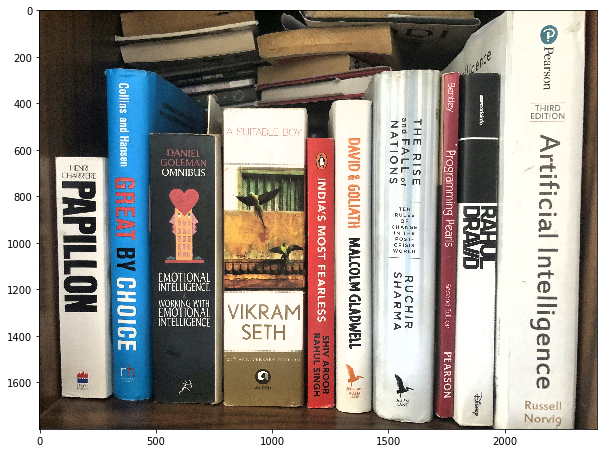

In [4]:
im_eq = utils.imgPreprocess(img)
utils.showImage(im_eq)

## Run Text Detection on the Image

In [5]:
frame, framev, boxes, indices = east.detectText(im_eq,0.5,0.3)

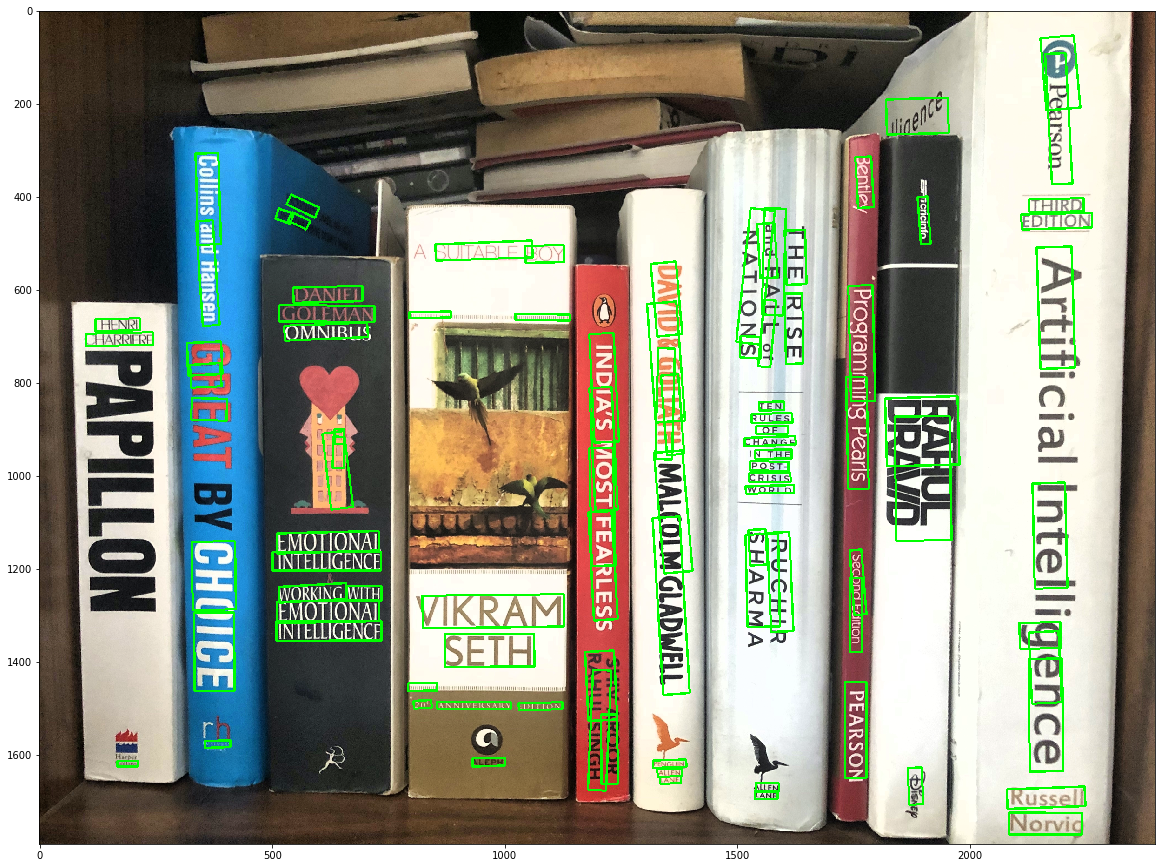

In [6]:
utils.showImage(framev,size=20)

## Use bounding boxes to separate out the books

#### Check how the whole bounding boxes thing works

In [7]:
indices[1]

array([2680], dtype=int32)

In [8]:
boxes[indices[1][0]]

((172.7839248920397, 707.4870865221203),
 (144.1421, 26.723934),
 -0.9647642202643011)

In [9]:
cv2.boxPoints(boxes[indices[1][0]])

array([[100.94806, 722.0606 ],
       [100.49811, 695.3405 ],
       [244.61978, 692.9135 ],
       [245.06973, 719.6336 ]], dtype=float32)

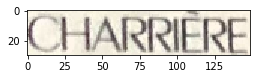

In [10]:
startX,endX,startY,endY = segment.getBBox(boxes[indices[1][0]],2)
utils.showImage(frame[startY:endY,startX:endX],size=4)

### Sort boxes based on min(x) and min(y)

In [11]:
sboxes = segment.getSortedBoxes(boxes,indices,0.05)

### Trim the start X and end X for each box
This is done to eliminate unnecessary borders from bounding boxes

In [12]:
sboxes = segment.trimBoxes(frame,sboxes)

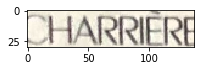

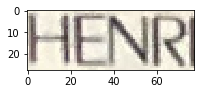

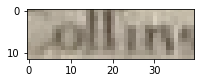

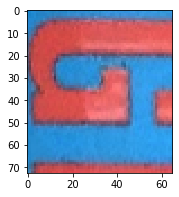

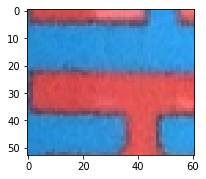

In [13]:
# Display some of the snippets using bounding boxes
for b in sboxes[:5]:
    utils.showImage(frame[
        b["minY"]:b["maxY"],
        b["minX"]:b["maxX"]
    ],size=3)

### Separate out the boxes into different books

We go through the sorted boxes in order and use a heauristic to segregate them into separate books

In [14]:
bookList = segment.boxesToBooks(sboxes, debug=True)
len(bookList)

current minX, maxX for book: 327 241
New Book
current minX, maxX for book: 519 419
New Book
current minX, maxX for book: 801 732
New Book
current minX, maxX for book: 1175 1139
New Book
current minX, maxX for book: 1330 1243
New Book
current minX, maxX for book: 1507 1387
New Book
current minX, maxX for book: 1736 1646
New Book
current minX, maxX for book: 1833 1796
New Book
current minX, maxX for book: 2090 1974
New Book


10

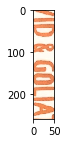

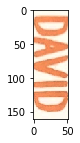

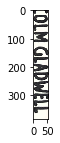

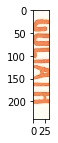

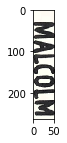

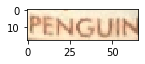

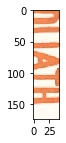

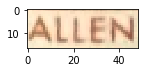

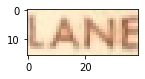

In [15]:
# Print images from one of the books
bookIdx= 5
for b in bookList[bookIdx]["boxes"]:
    utils.showImage(frame[ b["minY"]:b["maxY"], b["minX"]:b["maxX"] ],size=2)

### Create image block for each book

In [16]:
bookImages = segment.getBookImages(frame,bookList,padY=frame.shape[0])

### Show all segmented books

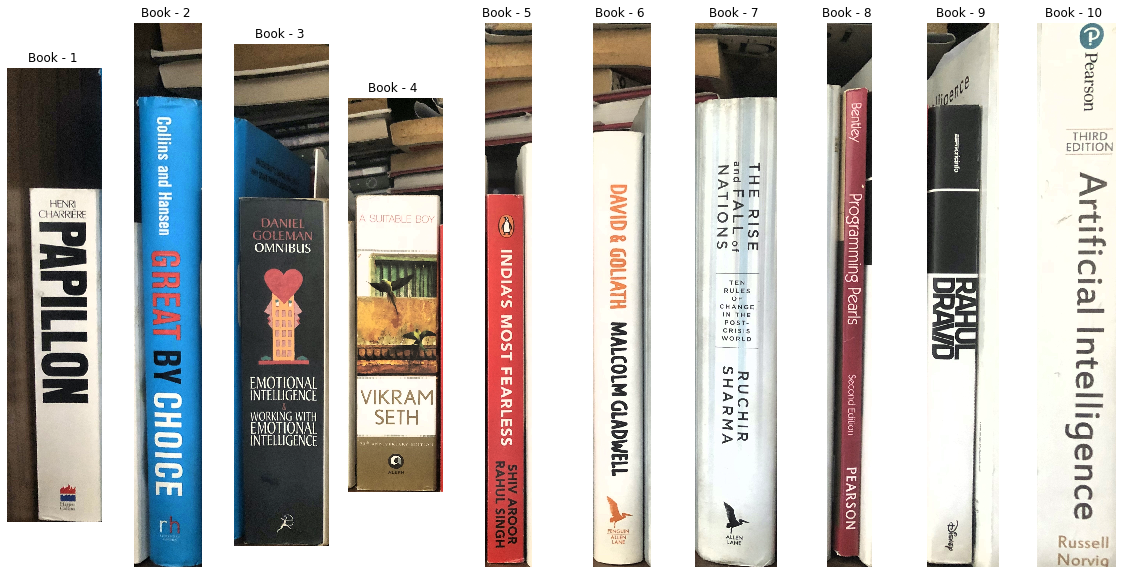

In [17]:
segment.showSegmentedBooks(bookImages)

In [18]:
# Dump all image blocks to the disk
import os

folder = 'images/books_slices'
if not os.path.exists(folder):
    os.makedirs(folder)

for i, bk in enumerate(bookImages):
    plt.imsave("{}/book_{:02d}.jpg".format(folder,i),\
               cv2.cvtColor(bk,cv2.COLOR_BGR2RGB))

## 

## Do OCR on the extracted images

We will be using [Google Vision API](https://cloud.google.com/vision/docs/ocr) to do the OCR, as pytesseract is simply not working for text with varying background. I tried to make it work with some preprocessing but just couldn't get the desired result. 

In [19]:
# Tesseract is simply not working, even with a lot of image preprocessing
#
#
# import pytesseract
# for i, bk in enumerate(bookImages):
#     print("\nBook: ",i)
#     print(pytesseract.image_to_string(np.rot90(bk)))

In [20]:
%aimport gocr

In [21]:
booksInfo = gocr.getAllBookLinks(bookImages)
booksInfo

[{'query': 'Harper\nPAPILLON\n',
  'title': 'Papillon (Harper Perennial Modern Classics)',
  'author': 'Henri Charrière',
  'google_link': 'https://play.google.com/store/books/details?id=d9evJVGHU7UC&source=gbs_api',
  'goodreads_link': 'https://www.goodreads.com/search?q=Papillon+(Harper+Perennial+Modern+Classics)+Henri+Charri%C3%A8re&search_type=books&search%5Bfield%5D=on'},
 {'query': 'GREAT BY CHOICE\nCollins and Hansen\n',
  'title': 'Great by Choice',
  'author': 'Jim Collins',
  'google_link': 'https://play.google.com/store/books/details?id=mQrNwkQkeGEC&source=gbs_api',
  'goodreads_link': 'https://www.goodreads.com/search?q=Great+by+Choice+Jim+Collins&search_type=books&search%5Bfield%5D=on'},
 {'query': 'DANIEL\nGOLEMAN\nOMNIBUS\nEMOTIONAL\nINTELLIGENCE\nWORKING WITH\nEMOTIONAL\nINTELLIGENCE\n',
  'title': 'Working with Emotional Intelligence',
  'author': 'Daniel Goleman',
  'google_link': 'https://play.google.com/store/books/details?id=fOnFvLIf8k0C&source=gbs_api',
  'goodrea